In [2]:
from pymdp import utils
import numpy as np
from scipy.stats import norm
import math
from pymdp.maths import softmax

import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr, config, jit
from pymdp.jax.agent import Agent as AIFAgent
from functools import partial
from equinox import tree_at

from pymdp.jax.maths import log_stable
import jax

# import pyglet
# from pyglet import shapes
import jax.numpy as jnp
from jax import jit

import matplotlib.pyplot as plt
import numpy as np 

import jax.numpy as jnp

from jax import jit
from jax.tree_util import tree_map
from functools import partial
import jax.random as jr

# config.update("jax_default_matmul_precision", "float32")
#config.update('jax_platform_name', 'cpu') # GPU使用可能環境下において、CPUで動かすときは実行する

#check jax
print(f'JAX v{jax.__version__} backend: {jax.default_backend()}')
print("devices:", jax.devices())


JAX v0.6.1 backend: cpu
devices: [CpuDevice(id=0)]


observations: 各自由度ごとに、角度(sin,cosで与える)と角速度と角加速度
states: 各自由度ごとに、角度(sin,cos)と角速度と角加速度
obsとstateが同じであるモデル
B行列に注目

In [9]:
#SimulationManagerを定義
import os
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import vonmises
import seaborn as sns
from pymdp import utils

class SimulationManager:
    def __init__(
            self,
            num_obs=None,
            num_states=None,
            num_controls=None,
            batch_size:int=1,
            num_history:int=16,
            isLearning: bool=True,
            isActive: bool=False,
            lr_pA:float=1.0,
            lr_pB:float=1.0,
            learn_A=True,
            learn_B=True,
            learn_D=False,
            Ainit='diagonal',
            Binit='random',
            dof:int=2,
            ):
        # # リンク機構のパラメータ
        # self.dof = 2 # 自由度

        # 生成モデルのパラメータ
        if num_obs is None:
            self.num_obs = [10,10,10,10,10,10,10,10] # 観測の次元数
        else:
            self.num_obs = num_obs
        self.num_modalities = len(self.num_obs) # 観測のモダリティ数
        if num_states is None:
            self.num_states = self.num_obs # 状態の次元数
        else:
            self.num_states = num_states
        self.num_factors = len(self.num_states) # 状態のファクタ数
        if num_controls is None:
            self.num_controls = [1 for _ in range(self.num_factors)] # 制御の次元数(制御なし)
        else:
            self.num_controls = num_controls
        self.dof = dof # 自由度

        # num_obsとnum_statesの形状を確認
        assert len(self.num_obs) == len(self.num_states), ("num_obs and num_states must be the same length")
        
        # 学習のパラメータ
        self.isActive  = isActive
        self.batch_size = batch_size # バッチサイズ
        self.num_history = num_history #  最大の履歴数（過去の状態・行動・観測を保持する数）
        self.lr_pA = lr_pA # Bの学習率
        self.lr_pB = lr_pB # Aの学習率
        self.learn_A = learn_A
        self.learn_B = learn_B
        self.learn_D = learn_D
        self.q_pi = None # ちゃんと定義して機体自由エネルギも計算するようにしたい

        self.A_dependencies = [[f] for f in range(self.num_factors)] # A行列の依存関係を定義
        
        n = int(len(self.num_obs)/self.dof)
        # if isActive:
        #     self.B_dependencies = [[f//n*n+i for i in range(n)] + [self.num_factors+f//n] for f in range(self.num_factors)] # B行列の依存関係を定義
        # self.B_dependencies = [[f//n*n+i for i in range(n)] for f in range(self.num_factors)] # B行列の依存関係を定義      

        self.B_dependencies = [[0,1], [0,1], [0,1,2], [1,2,3], [4,5], [4,5], [4,5,6], [5,6,7]]  
        # print(f"B_dependencies: {self.B_dependencies}")
        # 生成モデルを初期化
        self.Ainit = Ainit
        self.Binit = Binit
        self.initialize_A()
        self.initialize_B()
        self.initialize_C()
        self.initialize_D()
        self.initialize_pA()
        self.initialize_pB()

        for m in range(self.num_modalities):
            factor_dims = tuple([self.num_states[f] for f in self.A_dependencies[m]])
            # print(f"factor_dims: {factor_dims}\nA[m].shape: {self.A_jax[m].shape[2:]}")
            assert self.A_jax[m].shape[2:] == factor_dims, f"Please input an `A_dependencies` whose {m}-th indices correspond to the hidden state factors that line up with lagging dimensions of A[{m}]..."   
        for f in range(self.num_factors):
            factor_dims = tuple([self.num_states[f] for f in self.B_dependencies[f]])
            # print(f"factor_dims: {factor_dims}\nB[f].shape: {self.B_jax[f].shape[2:-1]}")
            assert self.B_jax[f].shape[2:-1] == factor_dims, f"Please input a `B_dependencies` whose {f}-th indices pick out the hidden state factors that line up with the all-but-final lagging dimensions of B[{f}]..." 
            
        # エージェントを初期化
        self.construct_agents()
        self.beliefs_last = np.ones((1, 1, self.num_states[0]), dtype=np.float32)  # 信念状態（qs）を 1 で初期化
        self.q_pi = utils.norm_dist_obj_arr(np.ones(self.num_controls)) # 各アクションの確率を均等に正規化
        
        # シミュレーションを初期化
        self.actions_t = 0  # 初期時刻では行動は未定義
        self.actions = None  # 過去の行動（初期時点では空）
        self.outcomes = None  # 過去の観測（初期時点では空）

        self.T: int = 0  # 現在の時刻（シミュレーションステップ）
        self.simT: int = 0  # シミュレーション全体のタイムステップ数
        self.obs_history = []  # 観測の履歴を記録するリスト

        assert self.D_jax is not None, ("D_jax is not defined")
        self.infer_args = (self.D_jax, None,)  # 状態推定アルゴリズムに渡す引数（D_jax, qs_hist）
        
        # --- VFEとEFEの記録 ---
        self.vfes: list[float] = []  # 変分自由エネルギーの時系列データ
        self.kld_history = []  # Kullback-Leiblerダイバージェンスの時系列データ
        self.bs_history = []  # ベイズサプライズの時系列データ
        self.un_history = []  # 不確実性の時系列データ
        self.efes: list[float] = []  # 期待自由エネルギーの時系列データ
        self.utility_history = []  # 効用（Pragmatic value）の時系列データ
        self.state_info_gain_history = []  # 状態情報ゲイン（pBS）の時系列データ
        self.pA_info_gain_history = []  # 観測モデル情報ゲイン（A行列に関するNovelty）の時系列データ
        self.pB_info_gain_history = []  # 遷移モデル情報ゲイン（B行列に関するNovelty）の時系列データ
        self.inductive_value_history = []  # 帰納的価値（inductive inferenceで用いられる項）の時系列データ

        # --- 履歴リストの初期化 ---
        self.actions_history = []  # 行動の履歴を記録するリスト
        self.beliefs_history = []  # 信念の履歴を記録するリスト
        self.qs_history = []       # 認識の履歴を記録するリスト
        self.FEparam = None

        # --- 学習設定 ---
        self.isLearning: bool = isLearning  # 学習の有効化（Falseに設定すると学習を無効化）
        Matrix_conpara_switch: bool = False  # モデル間の比較機能のスイッチ
        PauseFlag: bool = False  # 実行の一時停止フラグ


    def reset_simulation(self):
        """
        シミュレーションを初期化する関数
        """
        # シミュレーション設定
        self.actions_t = 0  # 初期時刻では行動は未定義
        self.actions = None  # 過去の行動（初期時点では空）
        self.outcomes = None  # 過去の観測（初期時点では空）

        self.T: int = 0  # 現在の時刻（シミュレーションステップ）
        self.simT: int = 0  # シミュレーション全体のタイムステップ数
        self.obs_history = []  # 観測の履歴を記録するリスト

        assert self.D_jax is not None, ("D_jax is not defined")
        self.infer_args = (self.D_jax, None,)  # 状態推定アルゴリズムに渡す引数（初期信念を含む）
        
        # --- VFEとEFEの記録 ---
        self.vfes: list[float] = []  # 変分自由エネルギーの時系列データ
        self.kld_history = []  # Kullback-Leiblerダイバージェンスの時系列データ
        self.bs_history = []  # ベイズサプライズの時系列データ
        self.un_history = []  # 不確実性の時系列データ
        #henkou
        self.efes: list[float] = []  # 期待自由エネルギーの時系列データ
        self.utility_history = []  # 効用（Pragmatic value）の時系列データ
        self.state_info_gain_history = []  # 状態情報ゲイン（pBS）の時系列データ
        self.pA_info_gain_history = []  # 観測モデル情報ゲイン（A行列に関するNovelty）の時系列データ
        self.pB_info_gain_history = []  # 遷移モデル情報ゲイン（B行列に関するNovelty）の時系列データ
        self.inductive_value_history = []  # 帰納的価値（inductive inferenceで用いられる項）の時系列データ

        # --- 履歴リストの初期化 ---
        self.actions_history = []  # 行動の履歴を記録するリスト
        self.beliefs_history = []  # 信念の履歴を記録するリスト
        self.qs_history = []       # 認識の履歴を記録するリスト
        self.FEparam = None

    #     # --- 学習設定 ---
    #     self.isLearning: bool = True  # 学習の有効化（Falseに設定すると学習を無効化）
    #     learningRateB: float = 1.0  # 状態遷移モデルの学習率
    #     Matrix_conpara_switch: bool = False  # モデル間の比較機能のスイッチ
    #     PauseFlag: bool = False  # 実行の一時停止フラグ

    # def initialize_GM(self, num_obs=None, num_states=None, num_controls=None, batch_size=None, default=False):
    #     """
    #     生成モデルを初期化する関数。
    #     シミュレーション結果は初期化しない。
    #     """
    #     # デフォルトの設定
    #     if default:
    #         self.num_obs = [10, 10]
    #         self.num_modalities = len(self.num_obs)
    #         self.num_states = [10, 10]
    #         self.num_factors = len(self.num_states)
    #         self.num_controls = [1 for _ in range(self.num_factors)]
    #         self.batch_size = 1

    #     # バッチサイズの設定
    #     if batch_size is not None:
    #         self.batch_size = batch_size
    #     else:
    #         batch_size = self.batch_size

    #     # 生成モデルの設定
    #     self.update_num_states_obs_controls(num_obs=num_obs, num_states=num_states, num_controls=num_controls)
    #     # 情報を表示
    #     if default:
    #         print("Default settings:")
    #     self.print_info()

    #     self.construct_agents()

    def reset_generative_model(self):
        """
        生成モデルを初期化する関数。
        シミュレーション結果は初期化しない。
        """
        self.initialize_A()
        self.initialize_B()
        self.initialize_C()
        self.initialize_D()
        self.initialize_pA()
        self.initialize_pB()

        # エージェントを再構築
        self.construct_agents()
        self.beliefs_last = np.ones((1, 1, self.num_states[0]), dtype=np.float32)  # 信念状態（qs）を 1 で初期化
        self.q_pi = utils.norm_dist_obj_arr(np.ones(self.num_controls)) # 各アクションの確率を均等に正規化

        # 情報を表示
        self.print_info()

    def update_lr(self, isLearning:bool=None, lr_pA=None, lr_pB=None):
        if isLearning is not None:
            self.isLearning = isLearning
        if lr_pA is not None:
            self.lr_pA = lr_pA
        if lr_pB is not None:
            self.lr_pB = lr_pB
        self.print_info()

    def initialize_A(self):
        A_shapes = [[no] + [self.num_states[fidx] for _, fidx in enumerate(self.A_dependencies[m])] for m, no in enumerate(self.num_obs)]
        if self.Ainit == 'flat':
            # 均一なAで初期化
            A = utils.obj_array_zeros(A_shapes)
            A = A + 1
            self.A = utils.norm_dist_obj_arr(A)
        elif self.Ainit == 'diagonal':
            # 対角行列で初期化
            A = utils.obj_array_zeros(A_shapes)
            for m in range(self.num_modalities):
                no = self.num_obs[m]
                for f, _ in enumerate(self.A_dependencies[m]):
                    ns = self.num_states[f]
                    for o in range(no):
                        for s in range(ns):
                            delta = np.abs(s-o)
                            if delta > ns/2:
                                delta = ns - delta
                            kappa = 2.0
                            A[m][o,s] = np.exp(kappa * np.cos(2 * np.pi * delta / ns))+0.01
            self.A = utils.norm_dist_obj_arr(A)
        else:
            assert False, ("Ainit must be 'flat' or 'diagonal'")
        # elif self.Ainit == 'random':
        #     # ランダムなAで初期化
        #     A = utils.random_A_matrix(self.num_obs, self.num_states)
        #     self.A = A
        # elif self.Ainit == 'diagonal':
        #     # 対角行列で初期化
        #     A = utils.initialize_empty_A(self.num_obs, self.num_states)
        #     for m, Am in enumerate(A):
        #         no = self.num_obs[m]
        #         for f in range(self.num_factors):
        #             ns = self.num_states[f]
        #             Amf = Am[f+1]
        #             for o in range(no):
        #                 for s in range(ns):
        #                     delta = np.abs(s-o)
        #                     if delta > ns/2:
        #                         delta = ns - delta
        #                     Amf[o,s] = 
                
        #         delta = np.abs(s - o)
        #         if delta > num_states / 2:
        #             delta = num_states - delta
        #         likelihood_tensor[o, s, m] = np.exp(kappa * np.cos(2 * np.pi * delta / num_states))

        #     A[] = 
        #     self.A = A
        self.A_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.A))
        return self.A
    
    # def initialize_A(self, kappa=2.0):
    #     """
    #     von Mises分布ベースで観測尤度A行列を初期化する
    #     kappa: von Mises分布の集中度（大きいと鋭くなる）
    #     """
    #     num_states = self.num_states
    #     num_obs = self.num_obs
    #     A_shape_list = [[no] + num_states for no in num_obs]
    #     A = utils.obj_array(len(A_shape_list))

    #     for i, shape in enumerate(A_shape_list):
    #         A_i = np.zeros(shape)
    #         n_obs = num_obs[i]
    #         n_states = num_states[i]

    #         # 観測カテゴリ (0〜n_obs-1)
    #         obs_vals = np.arange(n_obs)

    #         for s in range(n_states):
    #             # 各状態sのときのvon Mises分布
    #             # 状態カテゴリ番号を中心とする循環分布
    #             pdf_vals = vonmises.pdf(obs_vals * 2*np.pi/n_obs, kappa, loc=s * 2*np.pi/n_obs)
    #             pdf_vals /= pdf_vals.sum()  # 念のため正規化

    #             # A行列の[観測, 状態]に代入
    #             A_i[:, s] = pdf_vals

    #         A[i] = A_i
    #     self.A = A
    #     self.A_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.A))
    #     return self.A

    def initialize_B(self):
        if self.Binit == 'flat':
            # 均一なBで初期化
            B_shapes = [[ns] + [self.num_states[fidx] for _, fidx in enumerate(self.B_dependencies[f])] + [self.num_controls[f]] for f, ns in enumerate(self.num_states)]
            B = utils.obj_array_zeros(B_shapes)
            B = B + 1
            self.B = utils.norm_dist_obj_arr(B)
        elif self.Binit == 'random':
            B = utils.random_B_matrix(self.num_states, self.num_controls, self.B_dependencies)
            self.B = B
        else:
            assert False, ("Binit must be 'flat' or 'random'")
        self.B_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.B))
        return self.B
    
    def initialize_D(self, gain=5.0):
        # シグモイド型のDを定義
        D = utils.obj_array_ones([ns for ns in self.num_states])
        for i, _ in enumerate(self.num_states):
            x = np.linspace(-1, 1, len(D[i]))  # 入力範囲を[-1, 1]に設定
            D[i] = 1 / (1 + np.exp(-gain * x))  # シグモイド関数の適用
            D[i] /= np.sum(D[i])  # 正規化
        self.D = D
        self.D_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.D))
        return self.D
    
    def initialize_D_flat(self):
        D = utils.obj_array_ones([ns for ns in self.num_states])
        self.D = utils.norm_dist_obj_arr(D)
        return self.D
    
    def initialize_pA(self):
        # Aと同じ形のpAをディリクレ分布で初期化
        self.pA = utils.dirichlet_like(self.A)
        self.pA_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.pA))
        return self.pA
    
    def initialize_pB(self):
        # Bと同じ形のpBをディリクレ分布で初期化
        self.pB = utils.dirichlet_like(self.B)
        self.pB_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.pB))
        return self.pB

    def initialize_C(self):
        # 均一なCで初期化(選好なし)
        self.C = utils.obj_array_zeros([num_ob for num_ob in self.num_obs])
        self.C_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (self.batch_size,) + x.shape), list(self.C))
        return self.C

    def print_info(self):
        print(f'num_obs : {self.num_obs}')
        print(f'num_modalities : {self.num_modalities}')
        print(f'num_states : {self.num_states}')
        print(f'num_factors : {self.num_factors}')
        print(f'num_controls : {self.num_controls}')
        print(f'A[0].shape : {self.A[0].shape}')
        print(f'B[0].shape : {self.B[0].shape}')
        print(f'C : {self.C}')
        print(f'D : {self.D}')
        print(f'pA[0].shape : {self.pA[0].shape}')
        print(f'pB[0].shape : {self.pB[0].shape}')
        print(f'A is normalized : {utils.is_normalized(self.A)}')
        print(f'B is normalized : {utils.is_normalized(self.B)}')
        print(f'beliefs_last : {self.beliefs_last}')
        print(f'q_pi : {self.q_pi}')

    def construct_agents(self):
        assert self.A_jax is not None, ("Generative Model is not defined")
        self.agents = AIFAgent(
            A=self.A_jax,
            B=self.B_jax,
            C=self.C_jax,
            D=self.D_jax,
            E=None,
            pA=self.pA_jax,
            pB=self.pB_jax,
            A_dependencies=self.A_dependencies,
            B_dependencies=self.B_dependencies,
            onehot_obs=True,
            inference_algo="mmp",
            learn_A=self.learn_A,
            learn_B=self.learn_B,
            learn_D=self.learn_D,
            
        )

    def run(self, timesteps, env):
        """
        timesteps: シミュレーションを行う時間ステップ数
        env: env.current_obs(time)を持つ環境クラス
        """
        assert self.agents is not None, ("agents is not defined")
        simT_max = timesteps
        batch_keys = jr.split(jr.PRNGKey(0), self.batch_size)

        start_time = time.time()

        # タスク実行ループ
        while True:
            clockLB = time.time()
            clock = time.time()

            # 現在の観測を取得
            obs = env.current_obs(self.T)

            # 履歴に記録
            self.obs_history.append(obs)
            
            # 観測データを準備
            outcome_t = [jnp.expand_dims(jnp.expand_dims(o, 0), 0).astype(jnp.float32) for o in obs]

            # 観測履歴を更新
            if self.outcomes is None:
                self.outcomes = outcome_t
            else:
                self.outcomes = jtu.tree_map(lambda prev_o, new_o: jnp.concatenate([prev_o, new_o], 1), self.outcomes, outcome_t)

            # 能動推論エージェントを更新
            isLearning = self.isLearning
            # if self.lr_pA==0.0 and self.lr_pB==0.0:
            #     isLearning = False
            
            (
                self.agents,
                self.outcomes,
                self.actions,
                self.beliefs_last,
                self.infer_args,
                batch_keys,
                self.FEparam,
                self.q_pi
            ) = update_agent(
                self.agents,
                self.outcomes,
                self.actions,
                self.infer_args,
                batch_keys,
                batch_size=self.batch_size,
                isLearning=isLearning,
                lr_pB=self.lr_pB,
                lr_pA=self.lr_pA,
                num_history=self.num_history
            )

            # 各種メトリクスを記録
            # vfe関係
            self.vfes.append(self.FEparam['vfe'][0][0][-1])
            self.kld_history.append(self.FEparam['kld'][0][0][-1])
            self.bs_history.append(self.FEparam['bs'][0][0][-1])
            self.un_history.append(self.FEparam['un'][0][0][-1])
            # efe関係
            self.efes.append([-val for val in self.FEparam['neg_efe'][0]])
            self.utility_history.append([-val for val in self.FEparam['utility'][0]])
            self.state_info_gain_history.append([-val for val in self.FEparam['state_info_gain'][0]])
            self.pA_info_gain_history.append([-val for val in self.FEparam['pA_info_gain'][0]])
            self.pB_info_gain_history.append([-val for val in self.FEparam['pB_info_gain'][0]])
            self.inductive_value_history.append([-val for val in self.FEparam['inductive_value'][0]])
            # 信念状態の履歴を更新
            self.beliefs_history.append(self.beliefs_last)
            # 認識の履歴を更新
            current_qs = self.infer_args[1][-1]
            self.qs_history.append(current_qs)

            # 最新の行動を取得（環境に影響させない）
            self.actions_t = int(self.actions[:, 1, 0].item())
            # 行動履歴を記録
            self.actions_history.append(self.actions_t)

            # 時間ステップを更新
            self.T += 1
            self.simT += 1

            if self.simT > simT_max:
                break

            loopTimeRecord = {'AIF': (time.time() - clock) * 1000, 'all': (time.time() - clockLB) * 1000}

        # --- タスク終了時の処理 ---
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Task completed in {execution_time:.2f} seconds.")

        # --- メタデータの保存処理 ---
        if self.simT > 0:
            savedata = {
                'B': jax.device_get(self.agents.B),
                'A': jax.device_get(self.agents.A),
                'pB': jax.device_get(self.agents.pB),
                'pA': jax.device_get(self.agents.pA),
                'infer_args': self.infer_args,
                'agents': self.agents,
                'simT': self.simT,
                'T': self.T,
                'vfes': self.vfes,
                'kld_history': self.kld_history,
                'bs_history': self.bs_history,
                'un_history': self.un_history,
                'efes': self.efes,
                'utility_history': self.utility_history,
                'state_info_gain_history': self.state_info_gain_history,
                'pA_info_gain_history': self.pA_info_gain_history,
                'pB_info_gain_history': self.pB_info_gain_history,
                'inductive_value_history': self.inductive_value_history,
                'actions_history': self.actions_history,
                'obs_history': self.obs_history,
                'beliefs_history': self.beliefs_history,
                'qs_history': self.qs_history,
                'isLearning': self.isLearning,
                'lr_pA': self.lr_pA,
                'lr_pB': self.lr_pB
            }
            # 保存先ディレクトリのパス
            save_dir = "./test_data"

            # test_data フォルダがなければ作成
            os.makedirs(save_dir, exist_ok=True)
            # 現在の時刻を取得してファイル名に追加
            self.timestamp = time.strftime("%y%m%d%H%M%S", time.localtime())
            self.filename = f"./test_data/test_{self.timestamp}.pickle"

            with open(self.filename, mode='wb') as fo:
                pickle.dump(savedata, fo)

            print(f"Metadata has been saved to '{self.filename}'.")

    def plot_fe_all(
            self,
            filename=None,
            split_fe=True,
            vfe=True,
            kld=True,
            bs=True,
            un=True,
            efe=True,
            utility=True,
            state_ig=True,
            pA_ig=True,
            pB_ig=True,
            param_ig=True,
            inductive_val=True,
            actions=True,
            obs=True
            ):
        
        # データの取得
        # 保存したpickleファイルを読み込む
        if filename is not None:
            try:
                with open(filename, mode='rb') as fi:
                    loaded_data = pickle.load(fi)
                # データの取得
                vfes = loaded_data.get('vfes', [])
                efes = loaded_data.get('efes', [])
                kld_history = loaded_data.get('kld_history', [])
                bs_history = loaded_data.get('bs_history', [])
                un_history = loaded_data.get('un_history', [])
                utility_history = loaded_data.get('utility_history', [])
                state_info_gain_history = loaded_data.get('state_info_gain_history', [])
                pA_info_gain_history = loaded_data.get('pA_info_gain_history', [])
                pB_info_gain_history = loaded_data.get('pB_info_gain_history', [])
                inductive_value_history = loaded_data.get('inductive_value_history', [])  # Inductive Value の履歴を取得
                actions_history = loaded_data.get('actions_history', [])
                obs_history = loaded_data.get('obs_history', [])
                qs_history = loaded_data.get('qs_history', [])
            except FileExistsError:
                print(f"file '{filename} not found.")
            except Exception as e:
                print(f"An error occurred: {e}")

        # または現在保持しているデータ
        else:
            vfes = self.vfes
            efes = self.efes
            kld_history = self.kld_history
            bs_history = self.bs_history
            un_history = self.un_history
            utility_history = self.utility_history
            state_info_gain_history = self.state_info_gain_history
            pA_info_gain_history = self.pA_info_gain_history
            pB_info_gain_history = self.pB_info_gain_history
            inductive_value_history = self.inductive_value_history
            actions_history = self.actions_history
            obs_history = self.obs_history
            qs_history = self.qs_history

        # 自由エネルギーのプロット
        if vfe or kld or bs or un or efe or utility or state_ig or pA_ig or pB_ig or param_ig or inductive_val:
            plt.figure(figsize=(10, 5))
            # vfeのプロット
            if vfe or kld or bs or un:
                if vfe:
                    plt.plot(range(len(vfes)), vfes, label="VFE", color='orange')
                if kld:
                    plt.plot(range(len(kld_history)), kld_history, label="KLD", linestyle='dashed', color='red')
                if bs:
                    plt.plot(range(len(bs_history)), bs_history, label="BS", linestyle='dashed', color='blue')
                if un:
                    plt.plot(range(len(un_history)), un_history, label="UN", linestyle='dashed', color='grey')
                
                if split_fe: # efeと別でプロットする場合
                    plt.xlabel("Time Steps")
                    plt.ylabel("VFE and Components")
                    plt.title("VFE and Its Components Over Time")
                    plt.legend()
                    plt.grid()
                    plt.show()

            # efeのプロット
            if efe or utility or state_ig or pA_ig or pB_ig or param_ig or inductive_val:
                # 各指標の平均を計算
                efes_means = [np.mean(step) for step in efes]
                utility_means = [np.mean(step) for step in utility_history]
                state_info_gain_means = [np.mean(step) for step in state_info_gain_history]
                pA_info_gain_means = [-np.mean(step) for step in pA_info_gain_history]
                pB_info_gain_means = [-np.mean(step) for step in pB_info_gain_history]
                param_info_gain_means = [pA + pB for pA, pB in zip(pA_info_gain_means, pB_info_gain_means)]
                inductive_value_means = [np.mean(step) for step in inductive_value_history]  # Inductive Value の平均を計算
                
                if split_fe: # vfeと別でプロットする場合にもう一枚用意
                    plt.figure(figsize=(10, 5))

                if efe:
                    plt.plot(range(len(efes_means)), efes_means, label="EFE", color='lime')
                if utility:
                    plt.plot(range(len(utility_means)), utility_means, label="Utility", linestyle='dashed', color='gold')
                if state_ig:
                    plt.plot(range(len(state_info_gain_means)), state_info_gain_means, label="State Info Gain", linestyle='dashed', color='cyan')
                if pA_ig:
                    plt.plot(range(len(pA_info_gain_means)), pA_info_gain_means, label="Negative Novelty pA", linestyle='dashed', color='magenta')
                if pB_ig:
                    plt.plot(range(len(pB_info_gain_means)), pB_info_gain_means, label="Negative Novelty pB", linestyle='dashed', color='navy')
                if param_ig:
                    plt.plot(range(len(param_info_gain_means)), param_info_gain_means, label="Negative Novelty", linestyle='dashed', color='pink')
                if inductive_val:
                    plt.plot(range(len(inductive_value_means)), inductive_value_means, label="Inductive Value", linestyle='dashed', color='teal')

                if split_fe: # vfeと別でプロットする場合
                    plt.xlabel("Time Steps")
                    plt.ylabel("EFE and Components")
                    plt.title("EFE and Its Components Over Time")
                    plt.legend()
                    plt.grid()
                    plt.show()
                else:
                    plt.xlabel("Time Steps")
                    plt.ylabel("EFE and VFE")
                    plt.title("EFE and Its Components Over Time")
                    plt.legend()
                    plt.grid()
                    plt.show()

    def plot_A_all(self, batch_idx=0):
        # Aの形状はmodalityごとに(batch_size, [no] + [num_states])
        num_modalities = self.num_modalities
        num_factors = self.num_factors
        if num_modalities==1 and num_factors==1:
            A = self.agents.A[0][batch_idx,:,:]
            plt.figure(figsize=(10, 5))
            plt.title('Heatmap of A matrix')
            sns.heatmap(A, cmap="viridis")
            plt.xlabel('State Index')
            plt.ylabel('Observation Index')
            plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
            plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))
            plt.show()
            return
        else:
            # サブプロットの作成。各ヒートマップのサイズを調整
            fig, axes = plt.subplots(num_modalities, num_factors, figsize=(4*num_factors, 3*num_modalities))
            plt.title('A matrix heatmaps')
            
            # axesが2次元の場合も、1行または1列の場合も対応
            if num_modalities == 1:
                axes = axes[None, :]  # 1行に変換
            if num_factors == 1:
                axes = axes[:, None]  # 1列に変換

            for m, Am in enumerate(self.agents.A):
                # Amを [no]+num_states の形状に取る(lenはnum_factors+1となる)
                Am = Am[batch_idx]
                for f in range(Am.shape[0]):
                    # Amの中でのfのインデックス
                    dim = f + 1 # 0はobsのインデックスなので+1
                    # 平均を取る軸を整理
                    avg_axes = tuple(i for i in range(num_factors+1) if i not in (0, dim))
                    ax = axes[m, f]
                    Amf = Am.mean(axis=avg_axes)
                    sns.heatmap(Amf, ax=ax, cmap="viridis", cbar=True)
                    ax.set_title(f"Modality {m} - Factor {f}")
                    ax.set_xlabel("State Index")
                    ax.set_ylabel("Observtion Index")
            plt.tight_layout()
            plt.show()



    def plot_B_all(self, batch_idx=0):
        # 縦にfactor数、横にそのfactorと関連するfactor数*control数(の最大値）を持つサブプロットを作成
        cols = [len(self.B_dependencies[f]) * self.num_controls[f] for f in range(self.num_factors)]
        max_cols = max(cols)
        # print(f"cols: {cols}")
        # print(f"max_cols: {max_cols}")
        w_per_subplot = 3  # 横の1プロットあたり幅
        h_per_subplot = 2.5  # 縦の1プロットあたり高さ

        fig_width = w_per_subplot * max_cols
        fig_height = h_per_subplot * self.num_factors

        fig, axes = plt.subplots(self.num_factors, max_cols, figsize=(fig_width, fig_height))
        # fig, axes = plt.subplots(self.num_factors, max_cols, figsize=(3*self.num_factors, 4))
        fontsize = 16
        fig.suptitle('B matrix heatmaps', fontsize=fontsize)

        # axesが2次元の場合も、1行または1列の場合も対応
        if self.num_factors == 1:
            axes = axes[None, :]  # 1行に変換
        if max_cols == 1:
            axes = axes[:, None]  # 1列に変換

        # 現在の状態を表すfactorごとにＢを取り出す
        for factor, B in enumerate(self.B_jax):
            nc = self.num_controls[factor]
            B = np.array(B[batch_idx])

            # num_controls[f]の数だけ制御の通り数があるので、各制御に対して
            for c in range(self.num_controls[factor]):
                # controlを表すcごとにBを取り出す
                Bc = B[..., c]
                # factorに関連するfactor（fとする）それぞれに対して
                for fidx, f in enumerate(self.B_dependencies[factor]):
                    num_depend = len(self.B_dependencies[factor])
                    row = factor
                    col = c * len(self.B_dependencies[factor]) + fidx
                    ax = axes[row, col]
                    # Bの先頭は状態軸、その次が依存先状態軸群
                    # 平均を取る軸を整理
                    avg_axes = tuple(i for i in range(Bc.ndim) if i not in (0, f%num_depend+1))
                    B_mat = Bc.mean(axis=avg_axes)
                    # print(f"f: {f}")
                    # print(f"Bc.ndim: {Bc.ndim}")
                    # print(f"avg_axes: {avg_axes}")
                    # print(f"Bc.shape: {Bc.shape}")
                    # print(f"Bfcs.shape: {B_mat.shape}")
                    # print(B_mat)
                    sns.heatmap(B_mat, ax=ax, cmap="viridis", cbar=True)
                    ax.set_title(f"Factor(y) {factor} - Factor(x) {f} (Control {c})")
                    ax.set_xlabel("Next State")
                    ax.set_ylabel("Current State")
        fig.tight_layout(rect=[0, 0.03, 1, 0.99])

        plt.show()
                    

            # for col in range(max_cols):
            #     ax = axes[f, col]
            #     # 該当factorにc番目のcontrolがあればプロット、なければ非表示にする
            #     if col < cols[f]:
            #         c = col % nc  # controlのインデックス
            #         s = col // nc  # 状態のインデックス
            #         Bfc = Bf[..., c]
            #         # Bfの先頭は状態軸、その次が依存先状態軸群、最後がcontrol
            #         avg_axes = tuple(i for i in range(1, Bfc.ndim) if i not in (0, s))
            #         Bfcs = Bfc.mean(axis=avg_axes)
            #         print(f"Bfcs.shape: {Bfcs.shape}")
            #         print(Bfcs)
            #         sns.heatmap(Bfcs, ax=ax, cmap="viridis", cbar=True)
            #         ax.set_title(f"Factor(y) {f} - Factor(x) {s} (Control {c})")
            #         ax.set_xlabel("Next State")
            #         ax.set_ylabel("Current State")
            #     else:
            #         ax.axis('off')
            # plt.tight_layout()
            # plt.show()




In [10]:
# 知覚エージェントを更新する関数を定義
import jax.numpy as jnp
from jax import jit
from jax.tree_util import tree_map
from functools import partial
import jax.random as jr
    
    
# 知覚エージェントを更新する関数
@partial(jit, static_argnames=['batch_size', 'num_history', 'isLearning', 'isActive'])
def update_agent(
    agents,
    outcomes,
    actions,
    infer_args,
    batch_keys,
    batch_size=1,
    isLearning=True,
    lr_pA=1.0,
    lr_pB=1.0,
    num_history=16,
    isActive=False
    ):
    try:
        beliefs, _err, vfe, kld, bs, un = agents.infer_states_vfe(
            outcomes,
            infer_args[0], # 事前分布D
            past_actions=actions, # actions=Noneだとinference.update_posterior_states_vfeでB=Noneになって、algo.run_mmp_vfeに渡される
            qs_hist=infer_args[1] # 認識分布の履歴
        )
    except Exception as e:
        # infer_states_vfe が使えない場合のフォールバック
        print(f"Error in infer_states_vfe: {e}")
        beliefs = agents.infer_states(outcomes, infer_args[0], past_actions=actions, qs_hist=infer_args[1])
        vfe, kld, bs, un = [[[0.0]]], 0.0, 0.0, 0.0

    try:
        # ポリシー推定の詳細な計算（例えば効用や情報ゲインを含む）
        # CがNoneだとutility(を項に含むneg_efeも)が計算できない→均一なCを定義
        q_pi, neg_efe, G_info = agents.infer_policies_detail(beliefs)
    except Exception as e:
        # infer_policies_detail が使えない場合のフォールバック
        print(f"Error in infer_policies_detail: {e}")
        q_pi, neg_efe = agents.infer_policies(beliefs)
        G_info = {
            'utility': jnp.zeros_like(neg_efe),
            'state_info_gain': jnp.zeros_like(neg_efe),
            'pA_info_gain': jnp.zeros_like(neg_efe),
            'pB_info_gain': jnp.zeros_like(neg_efe),
            'inductive_value': [[0.0]]
        }

    # バッチサイズに基づいてランダムキーを分割
    batch_keys = jr.split(batch_keys[0], batch_size)

    # サンプリングによって次の行動を決定
    next_action = agents.sample_action(q_pi, rng_key=batch_keys)

    if not isActive:
        # ダミーのactionを定義（これによってactionの形状が元コードと異なるのでactions_historyに格納する処理も変更する必要あり）
        next_action = jnp.zeros((q_pi.shape[0], len(agents.num_controls)), dtype=int)

    # 過去の行動データに新しい行動を追加
    if actions is not None:
        actions = jnp.concatenate([actions, jnp.expand_dims(next_action, -2)], -2)
    else:
        actions = jnp.expand_dims(next_action, -2)

    # 観測・信念状態・行動を履歴の最大長（num_history）に制限
    outcomes = tree_map(lambda x: x[:, -num_history:], outcomes)
    beliefs = tree_map(lambda x: x[:, -num_history:], beliefs)
    actions = tree_map(lambda x: x[:, -num_history:], actions)

    # 信念状態（D）の更新
    # 使用する履歴が全履歴より短い場合に限定して更新
    # beliefsの長さを調節してから先頭をDに格納
    agents = tree_at(lambda x: x.D, agents, tree_map(lambda x: x[:, 0], beliefs))

    # 次の推論のために事前信念を更新
    infer_args = agents.update_empirical_prior(next_action, beliefs)

    # --- パラメータ学習フェーズ ---
    beliefs_last = tree_map(lambda x: x[:, -1:], beliefs)  # 最後の信念状態を取得
    if isLearning:
        # 最後の観測・行動・信念状態ペアを取得
        outcomes_last = tree_map(lambda x: x[:, -1:], outcomes)
        applied_actions_last = tree_map(lambda x: x[:, -2:-1], actions)
        beliefs_last_pair = tree_map(lambda x: x[:, -2:], beliefs)

        # パラメータ更新（観測モデルpA、状態遷移モデルpBなどを学習）
        agents = agents.infer_parameters(
            beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair,
            lr_pB=lr_pB + jnp.zeros(batch_size), lr_pA=lr_pA + jnp.zeros(batch_size)
        )

        # 更新されたエージェント、状態情報、メタデータなどを返す
    return agents, outcomes, actions, beliefs_last, infer_args, batch_keys, {
        #henkou
        'neg_efe': neg_efe,              # 負の期待自由エネルギー
        'vfe': vfe,                      # 変分自由エネルギー
        'kld': kld,                      # Kullback-Leiblerダイバージェンス
        'bs': bs,                        # ベイズサプライズ
        'un': un,                        # 不確実性
        #henkou
        'utility': G_info['utility'],    # 効用(-Risk-pF+pKLD，あるいはPragmatic value)
        'state_info_gain': G_info['state_info_gain'],  # 状態情報ゲイン(pBS)
        'pA_info_gain': G_info['pA_info_gain'],        # 観測モデル情報ゲイン(A行列に関するNovelty)
        'pB_info_gain': G_info['pB_info_gain'],        # 遷移モデル情報ゲイン(B行列に関するNovelty)
        'inductive_value': G_info['inductive_value']   # 帰納的価値(inductive inferenceという手法で用いられる項)
        }, q_pi #henkou


In [11]:
# 環境を定義
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# 環境
import jax.numpy as jnp
from jax import jit
from jax.tree_util import tree_map
from functools import partial
import jax.random as jr
from pymdp import utils


class TestEnv:
    def __init__(self, num_obs, num_timesteps):
        self.num_obs = num_obs
        self.num_timesteps = num_timesteps
        
    def current_obs(self, time):
        obs = [utils.onehot(int((time*no/self.num_timesteps)%no),no) for no in self.num_obs]
        return obs
    
class RandomEnv:
    """
    num_obs: エージェントに渡す観測の形状を指定する引数(agentと同じ)
     dof=2の場合(theta1, theta2)または(sin1,cos1,vel1,sin2,cos2,vel2)
    timesteps_cycle: エージェントに渡す観測の一周当たりの時間ステップ数
    num_cycle: 生成する動きの周回数
    num_knots_cycle: 一周分のスプラインを生成する際の制御点の個数（端点を含む）
    dof: 構造の自由度
    fps: 描画時のフレームレート
    duration_cycle: 描画時の一周あたりの秒数
    """
    def __init__(
        self,
        num_obs,
        timesteps_cycle,
        num_cycle=1,
        num_knots_cycle=5,
        dof=2,
        fps=30,
        duration_cycle=5,
        seed=0,
        isUniform=False
    ):
        self.isUniform = isUniform # 一様な観測を生成するかどうか
        self.num_obs = num_obs
        self.timesteps_cycle = timesteps_cycle
        self.num_cycle = num_cycle
        self.num_knots_cycle = num_knots_cycle
        self.dof = dof
        self.fps = fps
        self.duration_cycle = duration_cycle
        self.timesteps = timesteps_cycle * num_cycle # 全体の時間ステップ数
        self.duration = duration_cycle * num_cycle # 全体の秒数
        self.num_knots = num_knots_cycle * num_cycle + num_cycle + 1 # 全体のノット数
        self.t_knots = np.linspace(0, self.duration, self.num_knots) # ノットの時刻を決める配列
        self.t_knots_cycle = np.linspace(0, self.duration_cycle, self.num_knots_cycle) # ノットの時刻を決める配列
        self.splines = np.empty(self.dof, dtype=object) # 自由度ごとのスプラインを格納する変数(範囲：0-1)
        self.random_knots_cycle = np.empty(self.dof, dtype=object) # 自由度ごとのノットを格納する変数

        self.T = 0 # 時刻
        if self.isUniform is False:
            self.generate_random_spline_cycle()
        else:
            self.generate_uniform_spline_cycle()

    def generate_random_spline_cycle(self, bc_type='natural'):
        for pair in range(self.dof): # pairは対偶
            self.random_knots_cycle[pair] = np.random.rand(self.num_knots_cycle)
            self.random_knots_cycle[pair][0] = 0
            self.random_knots_cycle[pair][-1] = 1
            self.splines[pair] = CubicSpline(self.t_knots_cycle, self.random_knots_cycle[pair], bc_type=bc_type)

    def generate_uniform_spline_cycle(self, bc_type='natural'):
        for pair in range(self.dof): # pairは対偶
            self.random_knots_cycle[pair] = np.linspace(0, 1, self.num_knots_cycle)
            self.splines[pair] = CubicSpline(self.t_knots_cycle, self.random_knots_cycle[pair], bc_type=bc_type)


    # def current_obs(self, time):
    #     obs = [utils.onehot(int((spline(time))*no)%no, no) for no, spline in zip(self.num_obs, self.splines)]
    #     return obs
    
    # def arm_motion(self):
    #     pos_vectors = np.zeros([self.dof,2,self.num_frames])
    #     for pair,states in enumerate(self.states):
    #         length = 1#self.lengths[pair]
    #         poss = states[0]
    #         if pair==0:
    #             pos_vectors[pair] = length*(np.cos(poss), np.sin(poss))
    #         else:
    #             center = pos_vectors[pair-1]
    #             pos_vectors[pair] = center + length*(np.cos(poss), np.sin(poss))
    #     return pos_vectors

    # def current_obs(self, time):
    #     # num_obs: [sin1, cos1, vel1, sin2, cos2, vel2, ...]
    #     obs = [0]*len(self.num_obs)
    #     for pair in range(self.dof):
    #         # 角度の遷移を取得
    #         angle = self.splines[pair](time)
    #         # 角度からsin, cos, velを計算
    #         obs[pair*3] = np.sin(angle)
    #         obs[pair*3+1] = np.cos(angle)
    #         obs[pair*3+2] = self.splines[pair].derivative()(time)
    #     return obs
    
    def current_obs(self, time):
        time = time % self.timesteps_cycle
        obs = [0]*len(self.num_obs)
        n = int(len(self.num_obs) / self.dof)
        for idx, no in enumerate(self.num_obs):
            pair = idx // n
            angle = self.splines[pair](time)
            if idx % n == 0:# sin
                obs[idx] = utils.onehot(int((np.sin(angle)+1)/2 * (no-1) + 0.5), no) # sinの値を整数に変換してonehot化
            elif idx % n == 1:# cos
                obs[idx] = utils.onehot(int((np.cos(angle)+1)/2 * (no-1) + 0.5), no) # cosの値を整数に変換してonehot化
            elif idx % n == 2:# vel
                angle_vel = self.splines[pair].derivative()(time)
                max_angle_vel = np.max(np.abs(self.splines[pair].derivative()(self.t_dense())))
                angle_vel_norm = (angle_vel / (2 * max_angle_vel)) + 0.5
                angle_vel_idx = np.clip(int(angle_vel_norm * (no-1) + 0.5), 0, no-1)
                obs[idx] = utils.onehot(angle_vel_idx, no) # 角速度の値を整数に変換してonehot化
            elif idx % n == 3:
                angle_acc = self.splines[pair].derivative(2)(time)
                max_angle_acc = np.max(np.abs(self.splines[pair].derivative(2)(self.t_dense())))
                angle_acc_norm = (angle_acc / (2 * max_angle_acc)) + 0.5
                angle_acc_idx = np.clip(int(angle_acc_norm * (no-1) + 0.5), 0, no-1)
                obs[idx] = utils.onehot(angle_acc_idx, no)
        return obs

    def t_dense(self, num_plot_point=None):
        """
        num_plot_point: 時間軸の分解能
        """
        if num_plot_point is None:
            num_plot_point = self.timesteps_cycle
        t_dense = np.linspace(0, self.duration_cycle, num_plot_point)
        return t_dense

    def plot_obs_cycle(self, num_plot_point=None):
        """
        num_plot_point: 時間軸の分解能
        """
        if num_plot_point is None:
            num_plot_point = self.timesteps_cycle
        t_dense = np.linspace(0, self.duration_cycle, num_plot_point)
        fig, axes = plt.subplots(1, self.dof, figsize=(4*self.dof, 3))  # 横並びで自由度分のプロット
        fig.suptitle("Observetion Transition")
        if self.dof == 1:
            axes = [axes]  # 自由度1ならaxesもリスト化して扱いやすくする
        
        for pair in range(self.dof):
            obs_hist = self.splines[pair](t_dense)
            sns.lineplot(x=t_dense, y=obs_hist, ax=axes[pair])
            sns.pointplot(x=self.t_knots_cycle, y=self.random_knots_cycle[pair], ax=axes[pair])
            axes[pair].set_title(f'Pair: {pair}')
            axes[pair].set_xlabel('Time')
            axes[pair].set_ylabel('Angle')
        plt.tight_layout()
        plt.show()
        return t_dense

    def plot_obs_cycle(self, num_plot_point=None):
        if num_plot_point is None:
            num_plot_point = self.timesteps_cycle
        t_dense = np.linspace(self.t_knots_cycle[0], self.t_knots_cycle[-1], num_plot_point)
        fig, axes = plt.subplots(1, self.dof, figsize=(4*self.dof, 3))  # 横並びで自由度分のプロット

        if self.dof == 1:
            axes = [axes]
        fig.suptitle("Observation Transition")

        for pair in range(self.dof):
            obs_hist = self.splines[pair](t_dense)
            axes[pair].plot(t_dense, obs_hist, label='spline')
            axes[pair].scatter(self.t_knots_cycle, self.random_knots_cycle[pair], color='red', label='knots')
            axes[pair].set_title(f'Pair: {pair}')
            axes[pair].set_xlabel('Time')
            axes[pair].set_ylabel('Angle')
            axes[pair].legend()
            axes[pair].set_xlim(self.t_knots_cycle[0], self.t_knots_cycle[-1])  # 明示的にx軸範囲固定

        plt.tight_layout()
        plt.show()
        return t_dense


import os
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
from scipy.interpolate import splrep, splev
from scipy.interpolate import CubicSpline

class MotionSimulator():
    """
    引数
    fps: フレームレート
    duration: 動きの秒数
    num_states: 状態変数の種類数だけ各々の通り数を並べた配列
    状態変数三つ、各30通りの値を取るなら num_states=(30, 30, 30)
    """

    def __init__(
        self,
        fps: int=30,
        duration: float=5,
        dof: int=2,
        states: object=None
    ):
        self.fps = fps
        self.duration = duration
        self.dof = dof
        self.num_frames = int(self.fps * self.duration)
        self.t = np.linspace(0, self.duration, self.num_frames)
        self.states_shape = (self.dof, 3)
        self.data_shape = self.states_shape + (self.num_frames,)
        self.states = np.zeros(self.data_shape,dtype=np.float64)#shepe= (2, 3, 250)
        self.lengths = np.ones(self.dof,dtype=np.int32)
        self.knot_values = None
        self.t_knots = None

    def set_states(self, state, idx=False):
        if idx:
            self.states[idx] = state
        else:
            self.states = state
    
    def set_sample_motion(self):
        linear_poss = np.linspace(0, 2*math.pi, self.num_frames)
        for pair, states in enumerate(self.states):
            states[0] = linear_poss
        self.compute_kinematics()

    def generate_bspline(self, knots_values, bc_type='natural'):
        # boundary_conditions =
        # {
        #     'Natural': 'natural',
        #     'Clamped': ((1, 0.0), (1, 0.0)),
        #     'Periodic': 'periodic',
        #     'Not-a-Knot': 'not-a-knot'
        # }
        #生成するのは角度の遷移のみにする
        bc_type = ((1, 0.0), (1, 0.0))
        num_knots = len(knots_values)
        t_knots = np.linspace(0, self.duration, num_knots)
        #tck = splrep(t_knots, knots_values)
        #generated_states = splev(self.t, tck)
        spline = CubicSpline(t_knots, knots_values, bc_type=bc_type)
        generated_states = spline(self.t)
        return generated_states
    
    def random_knots(self, num_middle_knots, seed=0):
        np.random.seed(seed)
        middle_knots_values = np.random.rand(num_middle_knots) * 2*np.pi
        sbound = np.array([0.0])
        ebound = np.array([2*np.pi])
        knots_values = np.concatenate((sbound, middle_knots_values, ebound))
        return knots_values

    def set_random_motion(self, num_middle_knots, bc_type=None, seed=None):
        if not seed:
            seed = range(self.dof)
        self.knots_values = [self.dof]
        num_knots = num_middle_knots + 2
        self.t_knots = np.linspace(0, self.duration, num_knots)
        for pair, states in enumerate(self.states):
            knots_values = self.random_knots(num_middle_knots, seed=seed[pair])
            states[0] = self.generate_bspline(knots_values)#, bc_type=bc_type)
        return 

    def compute_kinematics(self):
        for pair,states in enumerate(self.states):
            poss = states[0]
            vels = np.gradient(poss, self.t)
            accs = np.gradient(vels, self.t)
            self.states[pair] = (poss, vels, accs)

    def plot_states(self):
        states = self.states
        rows, cols = self.states_shape
        t = self.t
        fig, axs = plt.subplots(rows, cols, figsize=(15,10))
        for i in range(self.dof):
            for j in range(3):
                # if j == 0:
                #     if self.knots_values:
                #         axs[i, j].plot(self.t_knots[i], self.knots_values[i], 'o', label='Control Points')
                axs[i, j].plot(t, states[i, j])
                axs[i, j].set_title(f'Subplot ({i}, {j})')
        plt.tight_layout()
        plt.show()

    def arm_motion(self):
        pos_vectors = np.zeros([self.dof,2,self.num_frames])
        for pair,states in enumerate(self.states):
            length = 1#self.lengths[pair]
            poss = states[0]
            if pair==0:
                pos_vectors[pair] = length*(np.cos(poss), np.sin(poss))
            else:
                center = pos_vectors[pair-1]
                pos_vectors[pair] = center + length*(np.cos(poss), np.sin(poss))
        return pos_vectors
    
    def show_motion(self, folder_path="results", filename='manipulator_motion', animation_type='small_sl'):
        pos_vectors = self.arm_motion()
        fig, ax = plt.subplots()
        full_length = np.sum(self.lengths)
        pict_lim = full_length + 1
        ax.set_xlim(-pict_lim, pict_lim)
        ax.set_ylim(-pict_lim, pict_lim)
        ax.set_aspect('equal')
        ax.axis('off')
        line, = ax.plot([], [], 'o-', lw=3, color='black', markerfacecolor='white', 
                        markeredgecolor='black', markeredgewidth=1)
        
        outer_circle = plt.Circle((0, 0), full_length+0.5, color='black', fill=False, linestyle='-')
        ax.add_artist(outer_circle)    

        if animation_type == 'small_sl':
            line_color = 'k'
            fps = self.fps
            t_values = self.t
        elif animation_type == 'large_sl':
            line_color = '#DDDDDD'
            fps = round(self.fps / 2)
            t_values = self.t[::2]

        def init():
            line.set_data([], [])
            return line,

        def update(frame):
            x_data = [0, pos_vectors[0, 0, frame], pos_vectors[1, 0, frame]]
            y_data = [0, pos_vectors[0, 1, frame], pos_vectors[1, 1, frame]]
            for pair in range(self.dof):
                x_data.append(pos_vectors[pair, 0, frame])
                y_data.append(pos_vectors[pair, 1, frame])
            x_data = [-x for x in x_data]  # 左右反転
            angle = - np.pi / 2  # 90度回転
            x_data, y_data = (np.cos(angle) * np.array(x_data) - np.sin(angle) * np.array(y_data), 
                              np.sin(angle) * np.array(x_data) + np.cos(angle) * np.array(y_data))
            line.set_data(x_data, y_data)
            return line,

        ani = FuncAnimation(fig, update, frames=len(t_values), init_func=init, blit=True)
        # GIFとして保存
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = filename + ".gif"
        gif_path = os.path.join(folder_path, filename)
        ani.save(gif_path, writer='imagemagick', fps=fps)

def plot_states(t,data):
    shape_plots = np.shape(data)
    rows, cols = shape_plots[0], shape_plots[1]
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    for i in range(rows):
        for j in range(cols):
            axs[i, j].plot(t, data[i, j])
            axs[i, j].set_title(f'Subplot ({i}, {j})')
    # plt.tight_layout()
    plt.show()


In [12]:
dim_obs = 10
num_obs = [dim_obs for _ in range(8)]
# [5,5,5,5,5,5,5,5]
num_states = num_obs
num_controls = None
lr_pB = 1.0
lr_pA = 1.0
num_history = 20
T_per_cycle = 20
Ainit = 'diagonal'
sim = SimulationManager(num_obs=num_obs,num_states=num_states,lr_pB=lr_pB,lr_pA=lr_pA,num_history=num_history,Ainit=Ainit, num_controls=num_controls)
# sim.print_info()
# sim.plot_B_all()

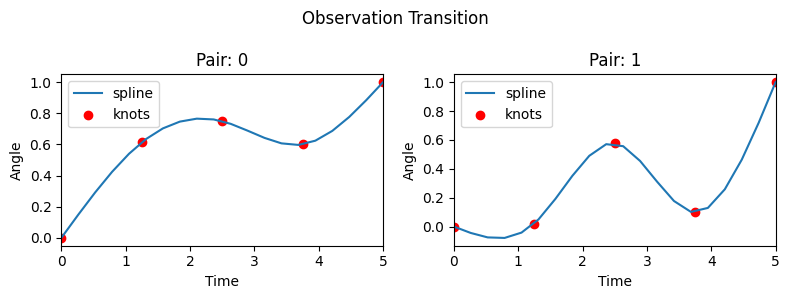

array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ])

In [13]:
env = RandomEnv(num_obs=sim.num_obs, timesteps_cycle=T_per_cycle)
env.plot_obs_cycle()

num_obs : [10, 10, 10, 10, 10, 10, 10, 10]
num_modalities : 8
num_states : [10, 10, 10, 10, 10, 10, 10, 10]
num_factors : 8
num_controls : [1, 1, 1, 1, 1, 1, 1, 1]
A[0].shape : (10, 10)
B[0].shape : (10, 10, 10, 1)
C : [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
D : [array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262, 0.19598849, 0.19866143])
 array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262, 0.19598849, 0.19866143])
 array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262

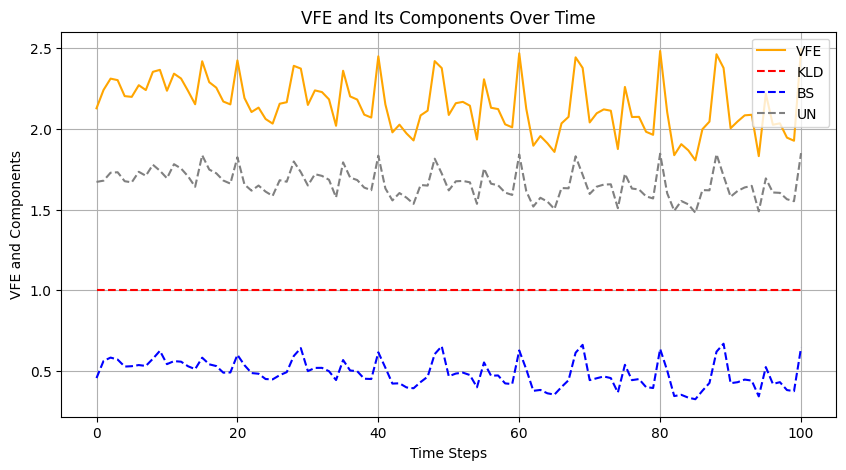

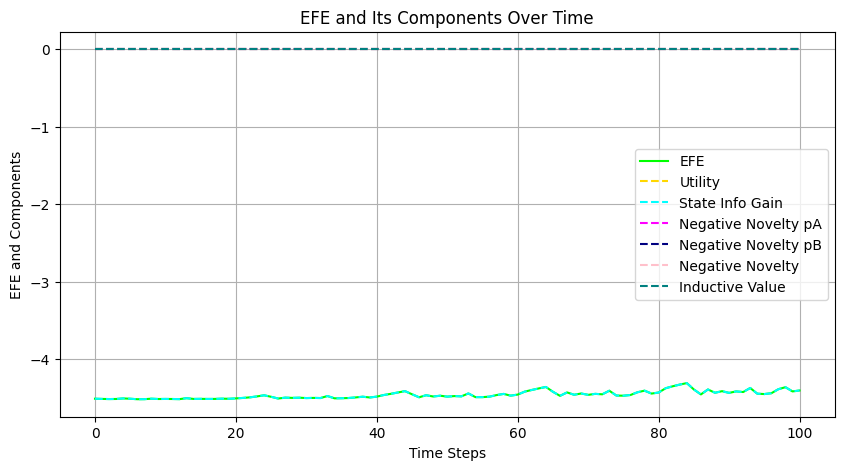

In [14]:
lr_pB = 1.0
lr_pA = 0.0
sim.reset_simulation()
sim.update_lr(lr_pB=lr_pB, lr_pA=lr_pA)
sim.reset_generative_model()
timesteps = 100
sim.run(env=env, timesteps=timesteps)
# sim.plot_B_all()
sim.plot_fe_all()

num_obs : [10, 10, 10, 10, 10, 10, 10, 10]
num_modalities : 8
num_states : [10, 10, 10, 10, 10, 10, 10, 10]
num_factors : 8
num_controls : [1, 1, 1, 1, 1, 1, 1, 1]
A[0].shape : (10, 10)
B[0].shape : (10, 10, 10, 1)
C : [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
D : [array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262, 0.19598849, 0.19866143])
 array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262, 0.19598849, 0.19866143])
 array([0.00133857, 0.00401151, 0.01170738, 0.03177382, 0.07291529,
        0.12708471, 0.16822618, 0.18829262

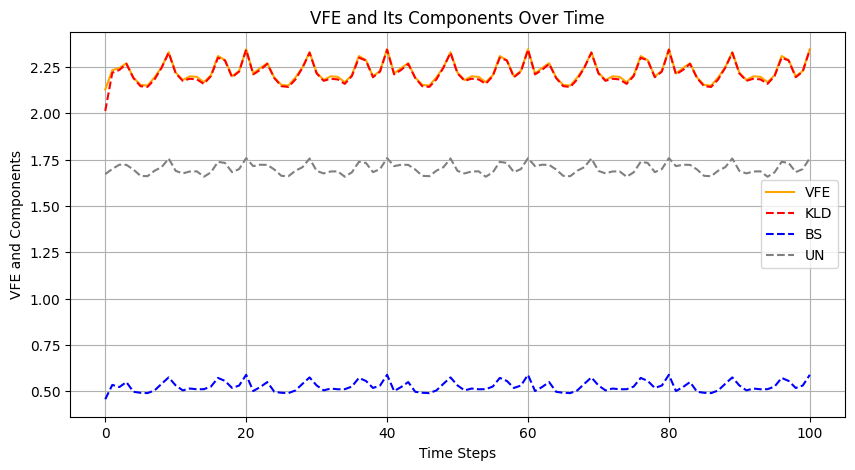

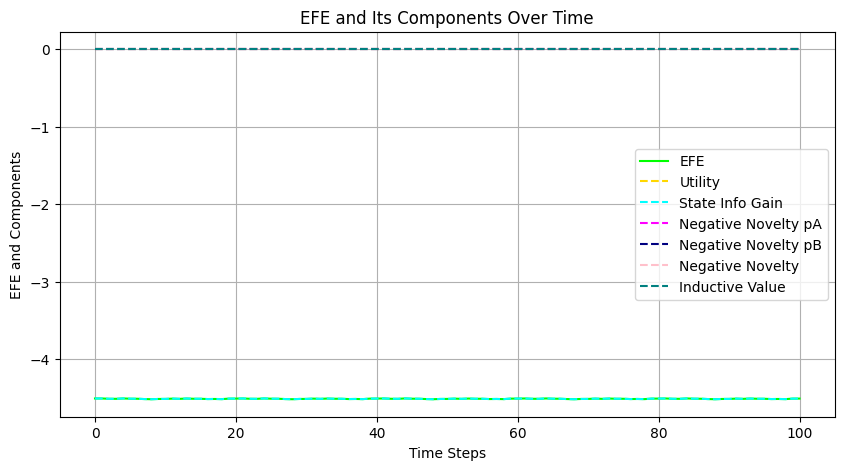

In [151]:
lr_pB = 0
lr_pA = 0
sim.reset_simulation()
sim.update_lr(lr_pB=lr_pB, lr_pA=lr_pA, isLearning=False)
timesteps = 100
sim.run(env=env, timesteps=timesteps)
# sim.plot_B_all()
sim.plot_fe_all()

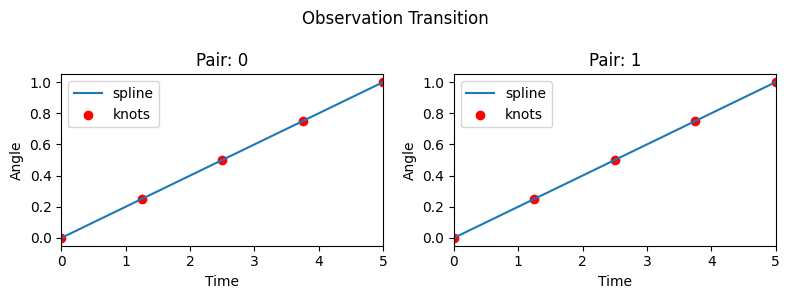

Task completed in 2.22 seconds.
Metadata has been saved to './test_data/test_250529015111.pickle'.


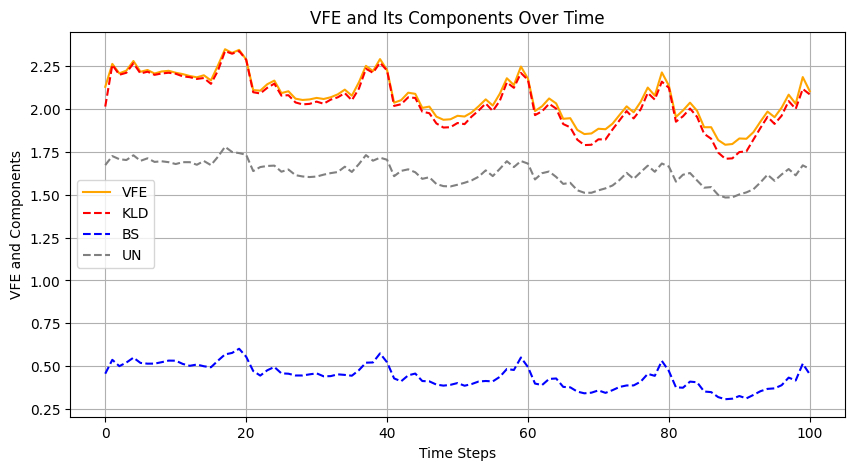

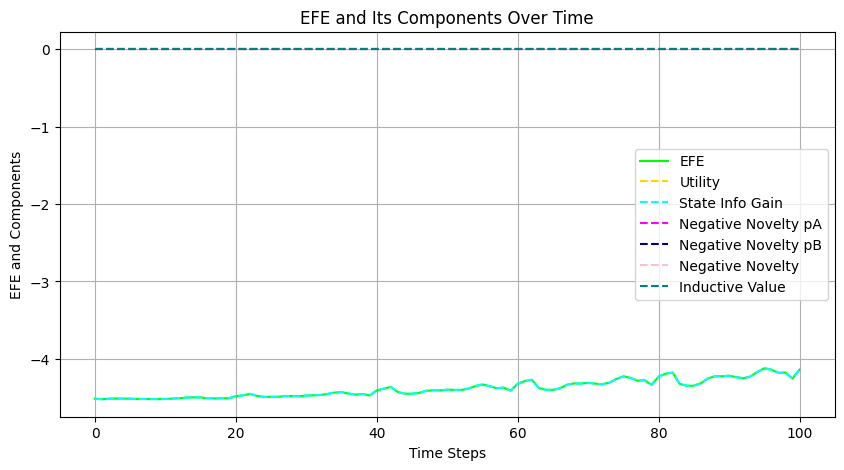

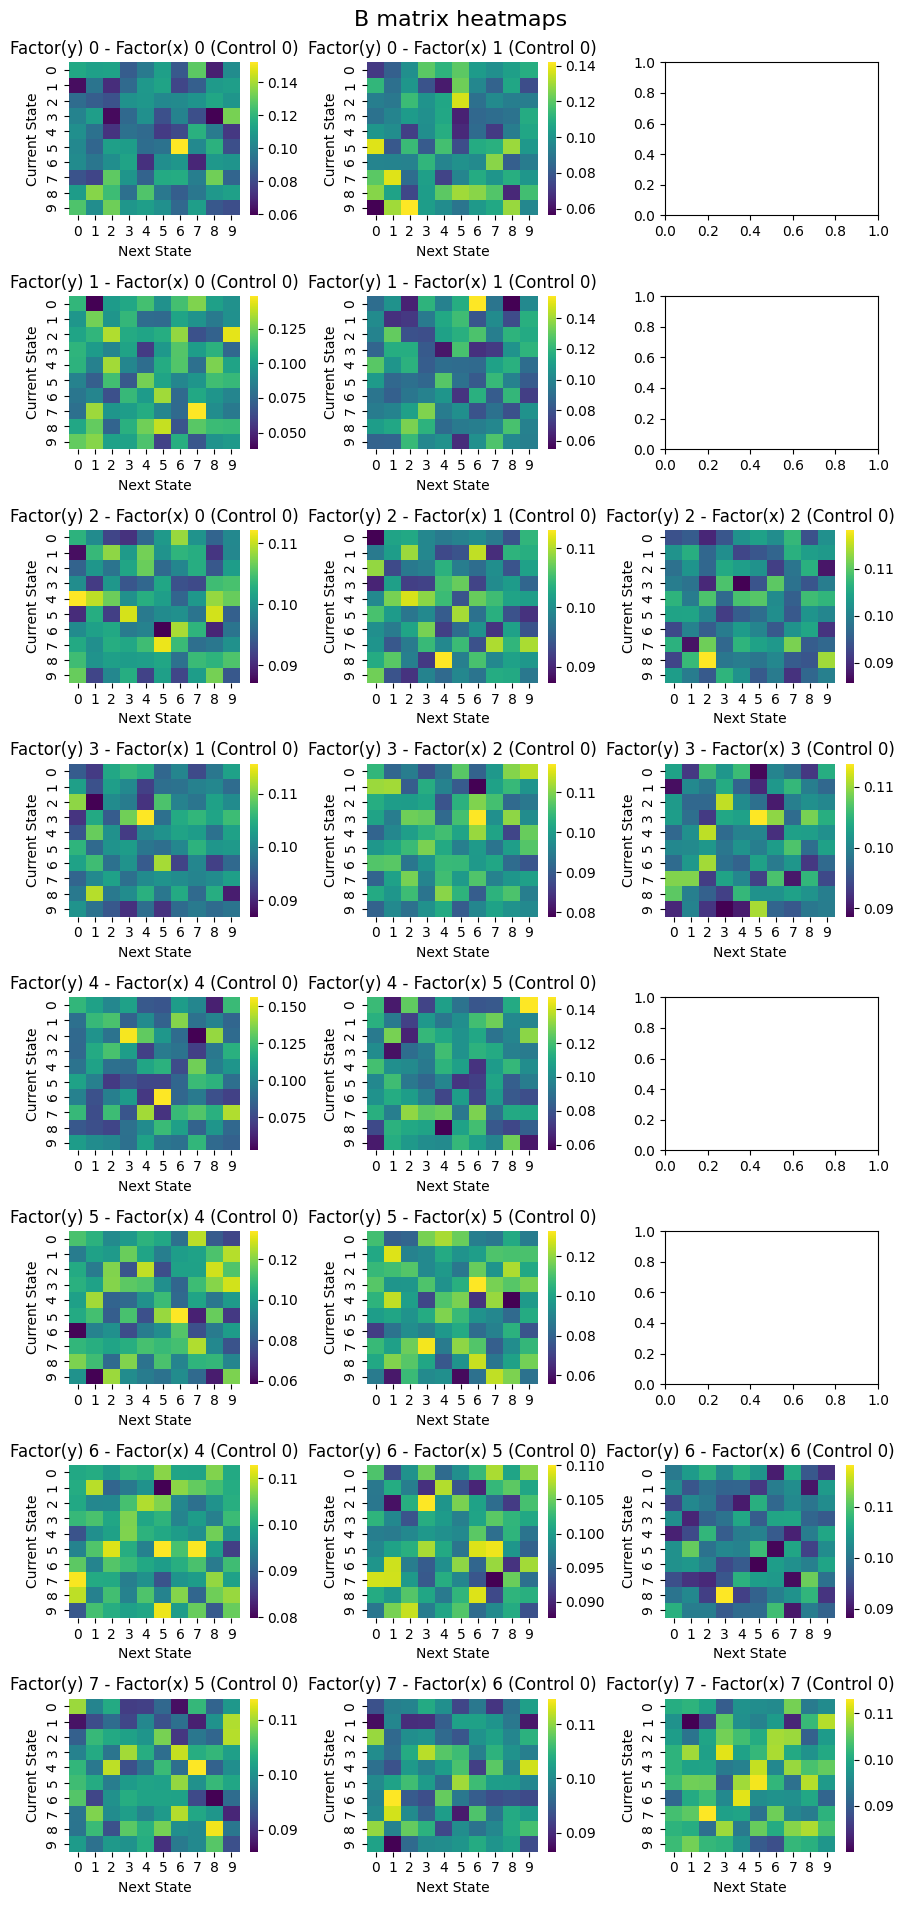

In [17]:
dim_obs = 10
num_obs = [dim_obs for _ in range(8)]
# [5,5,5,5,5,5,5,5]
num_states = num_obs
num_controls = None
lr_pB = 1.0
lr_pA = 0.0
num_history = 20
T_per_cycle = 20
Ainit = 'diagonal'
unisim = SimulationManager(num_obs=num_obs,num_states=num_states,lr_pB=lr_pB,lr_pA=lr_pA,num_history=num_history,Ainit=Ainit, num_controls=num_controls)
# sim.print_info()
# sim.plot_B_all()
unienv = RandomEnv(num_obs=unisim.num_obs, timesteps_cycle=T_per_cycle, isUniform=True)
unienv.plot_obs_cycle()
timesteps = 100
unisim.run(env=unienv, timesteps=timesteps)
unisim.plot_fe_all()
unisim.plot_B_all()

In [84]:
beliefs = sim.beliefs_history
qs = sim.qs_history
print(f"beliefs_hits: {beliefs}")
print(f"qs_hist: {qs}")

beliefs_hits: [[Array([[[6.6705550e-05, 2.9289641e-04, 2.3235944e-03, 2.1706389e-02,
         1.3540390e-01, 3.4577358e-01, 3.1239665e-01, 1.2863280e-01,
         3.8898360e-02, 1.4505075e-02]]], dtype=float32), Array([[[0.002282  , 0.00251587, 0.00213316, 0.0021298 , 0.00333581,
         0.00851848, 0.03065186, 0.11809026, 0.3341225 , 0.4962203 ]]],      dtype=float32), Array([[[0.002282  , 0.00251587, 0.00213316, 0.0021298 , 0.00333581,
         0.00851848, 0.03065186, 0.11809026, 0.3341225 , 0.4962203 ]]],      dtype=float32), Array([[[1.4398413e-04, 1.1729390e-03, 1.1782697e-02, 8.6925827e-02,
         2.9226968e-01, 3.4767455e-01, 1.6930844e-01, 5.5055514e-02,
         2.1081598e-02, 1.4584816e-02]]], dtype=float32), Array([[[6.6705550e-05, 2.9289641e-04, 2.3235944e-03, 2.1706389e-02,
         1.3540390e-01, 3.4577358e-01, 3.1239665e-01, 1.2863280e-01,
         3.8898360e-02, 1.4505075e-02]]], dtype=float32), Array([[[0.002282  , 0.00251587, 0.00213316, 0.0021298 , 0.00333581,
   

In [ ]:
sim.update_lr(lr_pB)

(1, 16, 10)

In [86]:
qs[0].shape

(1, 1, 10)

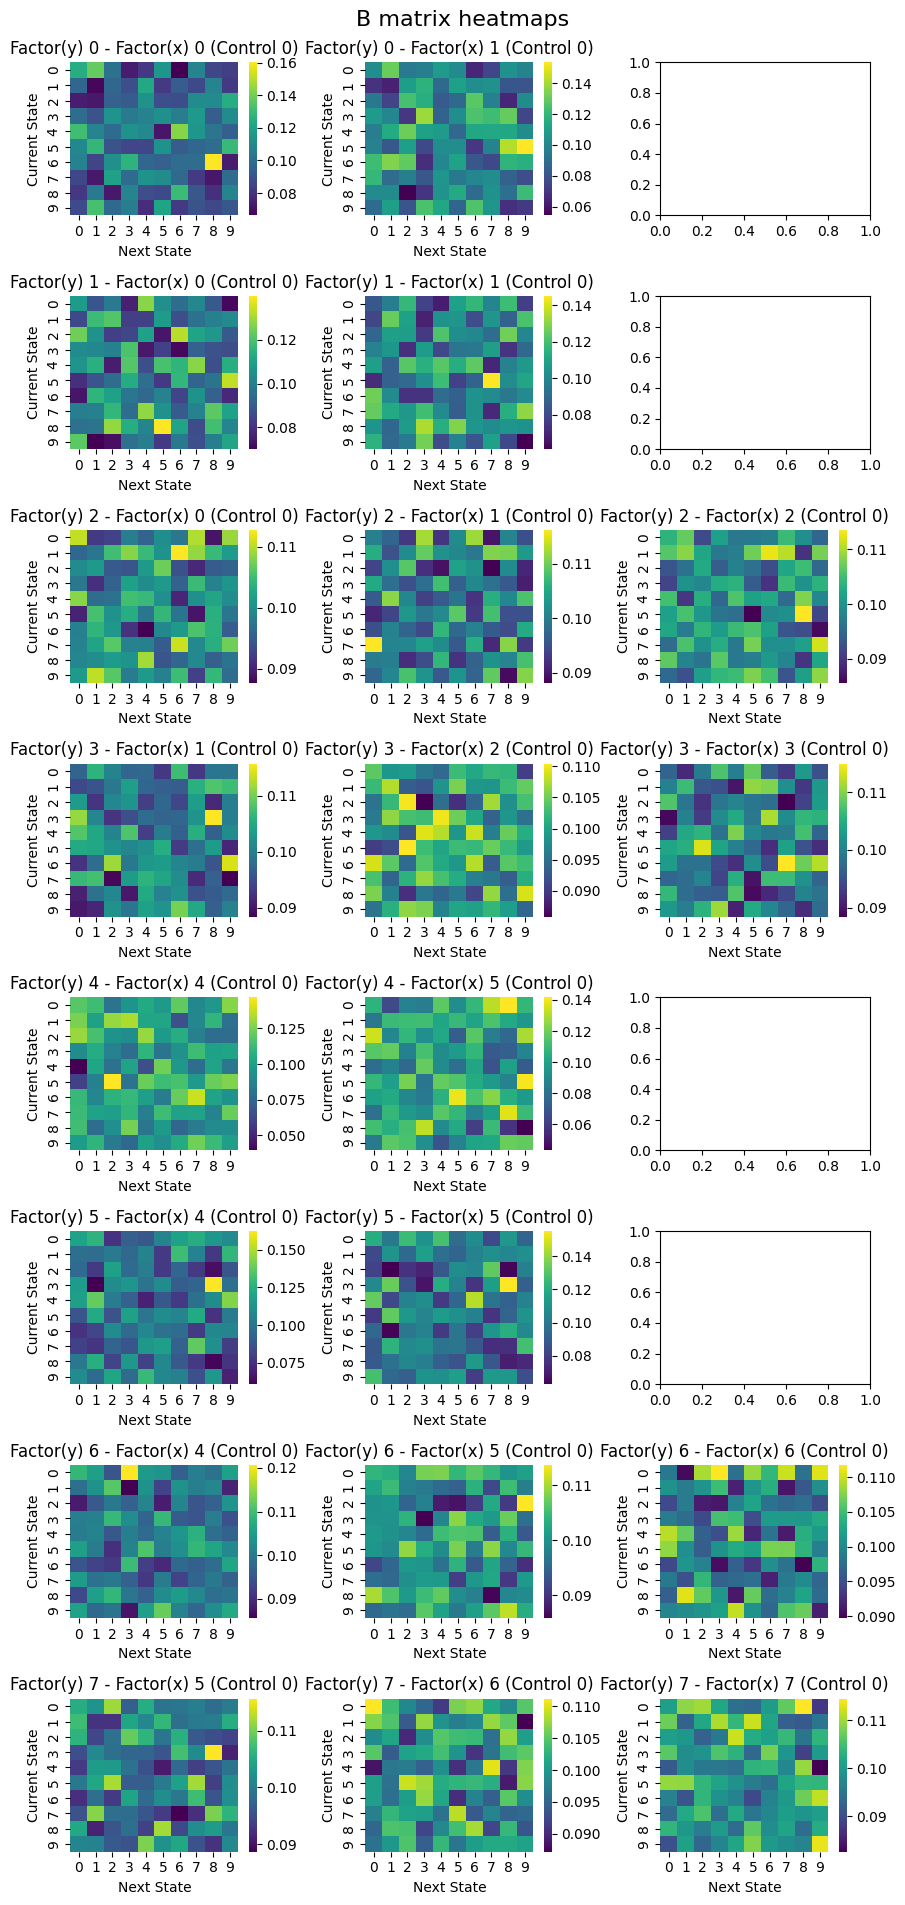

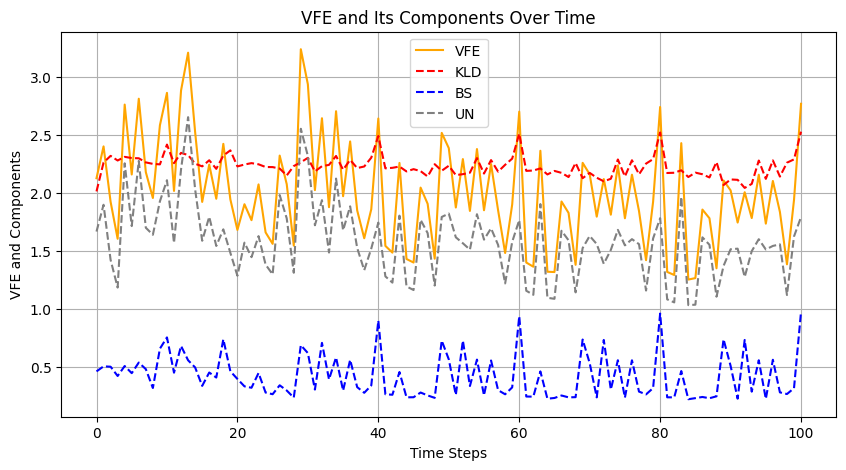

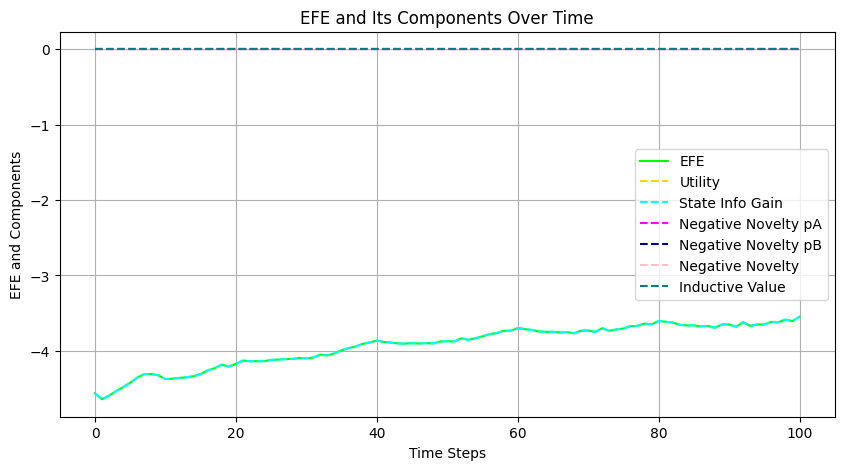

In [87]:
# sim.plot_A_all()
sim.plot_B_all()
sim.plot_fe_all()

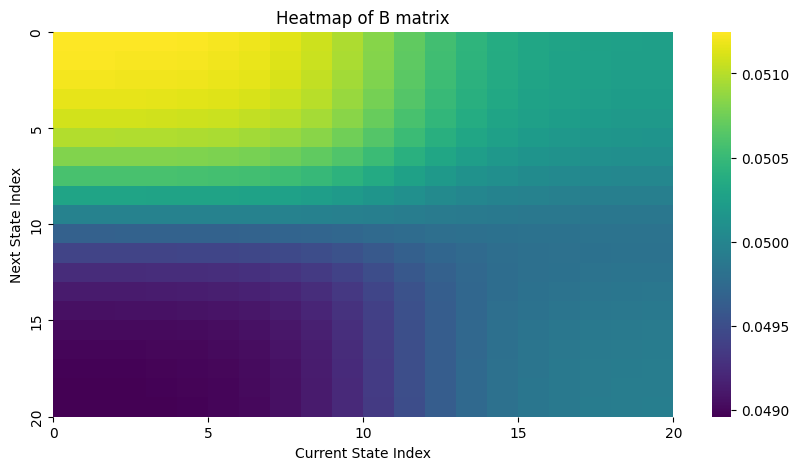

In [10]:
sim.plot_B_all()

In [20]:
print(sim.qs_history)
print(sim.beliefs_history)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[0.26894143, 0.73105854]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32), Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32)], [Array([[[0.03940417, 0.9605959 ]]], dtype=float32), Array([[[0.02022097, 0.97977895]]], dtype=float32), Array([[[0.01552733, 0.9844727 ]]], dtype=float32), Array([[[0.6169017, 0.3830983]]], dtype=float32), Array([[[0.02563065, 0.97436935]]], dtype=float32), Array([[[0.02153519, 0.97846484]]], dtype=float32), Array([[[0.02229781, 0.97770226]]], dtype=float32), Array([[[0.99056983, 0.00943015]]], dtype=float32

In [27]:
qs=sim.infer_args[1]

In [34]:
qs[0]

Array([[[0.04766217, 0.95233786],
        [0.04209932, 0.95790064],
        [0.03030311, 0.9696968 ],
        [0.9967219 , 0.00327807],
        [0.18788466, 0.81211543],
        [0.9975103 , 0.00248968],
        [0.99791723, 0.00208274],
        [0.15157828, 0.84842175],
        [0.05984974, 0.94015026],
        [0.99777204, 0.00222791],
        [0.9984093 , 0.00159068],
        [0.9982603 , 0.00173965],
        [0.9983722 , 0.00162776],
        [0.99836415, 0.00163585],
        [0.9984003 , 0.00159979],
        [0.99837863, 0.00162134]]], dtype=float32)

In [39]:
sim.beliefs_history[0]

[Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[0.26894143, 0.73105854]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32),
 Array([[[1.2339458e-04, 9.9987662e-01]]], dtype=float32)]